In [1]:
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
# training_filename = '/panfs/ccds02/nobackup/projects/hls/HLS/mwooten3/hls_agb/data/vector/l2al4a_metrics_pts_test2.gpkg'
training_filename = '/panfs/ccds02/nobackup/projects/hls/HLS/mwooten3/hls_agb/data/vector/l2al4a_metrics_pts.gpkg'

In [3]:
# open the training dataframe
training_df = gpd.read_file(training_filename)
training_df.head()

,time,flags,agbd,shot_number,beam,sensitivity,solar_elevation,elevation,vegmask_2022,rh98,...,HLS.M30.2022.12.v2.0.NIR_Edge1,HLS.M30.2022.12.v2.0.NIR_Edge2,HLS.M30.2022.12.v2.0.NIR_Edge3,HLS.M30.2022.12.v2.0.NIR_Broad,HLS.M30.2022.12.v2.0.NIR_Narrow,HLS.M30.2022.12.v2.0.SWIR1,HLS.M30.2022.12.v2.0.SWIR2,HLS.M30.2022.12.v2.0.Fmask,HLS.M30.2022.12.v2.0.ValidCount,geometry
0,2020-09-28T04:50:08.564000,134,152.493103,ft101660600400700992,6,0.962897,-51.241867,486.805115,3.0,29.570000,...,0.141101,0.215327,0.239768,0.240055,0.257107,0.303750,0.194226,0.0128,1.0,POINT (678678.7 -2367775.964)
1,2020-09-28T04:50:08.564000,134,152.493103,ft101660600400700992,6,0.962897,-51.241867,486.805115,3.0,29.570000,...,0.141101,0.215327,0.239768,0.240055,0.257107,0.303750,0.194226,0.0128,1.0,POINT (678678.7 -2367775.964)
2,2020-09-28T04:50:08.572000,134,52.618706,ft101660600400700993,6,0.981048,-51.241344,488.391388,3.0,15.570000,...,0.229034,0.286102,0.304902,0.299906,0.310494,0.414148,0.293381,0.0064,1.0,POINT (678714.22 -2367820.444)
3,2020-09-28T04:50:08.572000,134,52.618706,ft101660600400700993,6,0.981048,-51.241344,488.391388,3.0,15.570000,...,0.229034,0.286102,0.304902,0.299906,0.310494,0.414148,0.293381,0.0064,1.0,POINT (678714.22 -2367820.444)
4,2020-04-30T02:13:06.571000,134,64.095108,ft78240600100128796,6,0.973422,-78.872421,485.562012,3.0,28.190001,...,0.074462,0.238805,0.291943,0.292075,0.319980,0.158592,0.066478,0.0064,1.0,POINT (681154.607 -2368179.321)


In [4]:
# get some information about the data
training_df.describe()

,flags,agbd,beam,sensitivity,solar_elevation,elevation,vegmask_2022,rh98,vegage_2022,reg_fito_af_class,...,HLS.M30.2022.12.v2.0.Red,HLS.M30.2022.12.v2.0.NIR_Edge1,HLS.M30.2022.12.v2.0.NIR_Edge2,HLS.M30.2022.12.v2.0.NIR_Edge3,HLS.M30.2022.12.v2.0.NIR_Broad,HLS.M30.2022.12.v2.0.NIR_Narrow,HLS.M30.2022.12.v2.0.SWIR1,HLS.M30.2022.12.v2.0.SWIR2,HLS.M30.2022.12.v2.0.Fmask,HLS.M30.2022.12.v2.0.ValidCount
count,2861722.0,2.861722e+06,2.861722e+06,2.861722e+06,2.861722e+06,2.861722e+06,2.861722e+06,2.861722e+06,2.861722e+06,2.861722e+06,...,185254.000000,153778.000000,153778.000000,153778.000000,153778.000000,185254.000000,185254.000000,185254.000000,185254.000000,600556.000000
mean,134.0,8.435286e+01,7.553414e+00,9.817832e-01,-4.237679e+01,7.817312e+02,3.097954e+00,1.612666e+01,4.580203e+00,2.247058e+00,...,0.057944,0.111632,0.274173,0.330785,0.332880,0.358867,0.235710,0.120883,0.010570,0.326882
std,0.0,1.168242e+02,2.304721e+00,1.095017e-02,2.335381e+01,2.876976e+02,2.972529e-01,9.033880e+00,9.409898e+00,1.539664e+00,...,0.036883,0.035281,0.049147,0.073384,0.074696,0.074454,0.059216,0.050044,0.004252,0.504688
min,134.0,2.870049e-10,5.000000e+00,9.500001e-01,-8.959904e+01,5.313521e+01,3.000000e+00,1.910000e+00,0.000000e+00,1.000000e+00,...,0.003631,0.010400,0.008000,0.011200,0.006600,0.007200,0.006800,0.005762,0.006400,0.000000
25%,134.0,6.947686e+00,6.000000e+00,9.728565e-01,-6.063570e+01,6.072335e+02,3.000000e+00,9.130000e+00,0.000000e+00,1.000000e+00,...,0.030500,0.085751,0.243823,0.284381,0.286393,0.312248,0.191178,0.082520,0.006400,0.000000
50%,134.0,4.618480e+01,8.000000e+00,9.862304e-01,-4.540420e+01,7.910137e+02,3.000000e+00,1.500000e+01,0.000000e+00,2.000000e+00,...,0.047111,0.103339,0.272803,0.324781,0.327738,0.356363,0.224154,0.108741,0.011589,0.000000
75%,134.0,1.186436e+02,1.100000e+01,9.906171e-01,-2.143906e+01,9.309335e+02,3.000000e+00,2.123000e+01,2.000000e+00,2.000000e+00,...,0.071380,0.131117,0.304653,0.367762,0.371004,0.400548,0.272072,0.146019,0.012800,1.000000
max,134.0,4.431571e+03,1.100000e+01,9.979824e-01,-2.011524e-04,2.542155e+03,4.000000e+00,1.413600e+02,3.700000e+01,1.500000e+01,...,0.382347,0.384243,0.528000,0.645100,0.648900,0.721290,0.514123,0.458400,0.023103,3.000000


In [5]:
# Identify HLS predictors
hls_cols = [
    col for col in training_df.columns 
    if col.startswith("HLS.M30") and 
       not col.endswith(("NIR_Edge1", "NIR_Edge2", "NIR_Edge3", "NIR_Broad", "Fmask", "ValidCount"))
]
hls_cols[:3]

['HLS.M30.2020.01.v2.0.Coastal_Aerosol',
 'HLS.M30.2020.01.v2.0.Blue',
 'HLS.M30.2020.01.v2.0.Green']

In [6]:
# Extract time info
time_index = sorted(set([
    ".".join(col.split(".")[2:4])  # e.g. 2022.12
    for col in hls_cols
]))
time_index[:3]

['2020.01', '2020.02', '2020.03']

In [7]:
# Group bands per timestamp
hls_by_time = {
    t: [col for col in hls_cols if f".{t}." in col] for t in time_index
}
hls_by_time

{'2020.01': ['HLS.M30.2020.01.v2.0.Coastal_Aerosol',
  'HLS.M30.2020.01.v2.0.Blue',
  'HLS.M30.2020.01.v2.0.Green',
  'HLS.M30.2020.01.v2.0.Red',
  'HLS.M30.2020.01.v2.0.NIR_Narrow',
  'HLS.M30.2020.01.v2.0.SWIR1',
  'HLS.M30.2020.01.v2.0.SWIR2'],
 '2020.02': ['HLS.M30.2020.02.v2.0.Coastal_Aerosol',
  'HLS.M30.2020.02.v2.0.Blue',
  'HLS.M30.2020.02.v2.0.Green',
  'HLS.M30.2020.02.v2.0.Red',
  'HLS.M30.2020.02.v2.0.NIR_Narrow',
  'HLS.M30.2020.02.v2.0.SWIR1',
  'HLS.M30.2020.02.v2.0.SWIR2'],
 '2020.03': ['HLS.M30.2020.03.v2.0.Coastal_Aerosol',
  'HLS.M30.2020.03.v2.0.Blue',
  'HLS.M30.2020.03.v2.0.Green',
  'HLS.M30.2020.03.v2.0.Red',
  'HLS.M30.2020.03.v2.0.NIR_Narrow',
  'HLS.M30.2020.03.v2.0.SWIR1',
  'HLS.M30.2020.03.v2.0.SWIR2'],
 '2020.04': ['HLS.M30.2020.04.v2.0.Coastal_Aerosol',
  'HLS.M30.2020.04.v2.0.Blue',
  'HLS.M30.2020.04.v2.0.Green',
  'HLS.M30.2020.04.v2.0.Red',
  'HLS.M30.2020.04.v2.0.NIR_Narrow',
  'HLS.M30.2020.04.v2.0.SWIR1',
  'HLS.M30.2020.04.v2.0.SWIR2'],
 '2020.0

In [8]:
# Check availability per time
availability = pd.DataFrame({
    t: training_df[cols].notna().mean(axis=1) for t, cols in hls_by_time.items()
})
availability

,2020.01,2020.02,2020.03,2020.04,2020.05,2020.06,2020.07,2020.08,2020.09,2020.10,...,2022.03,2022.04,2022.05,2022.06,2022.07,2022.08,2022.09,2022.10,2022.11,2022.12
0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2861717,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2861718,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2861719,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2861720,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


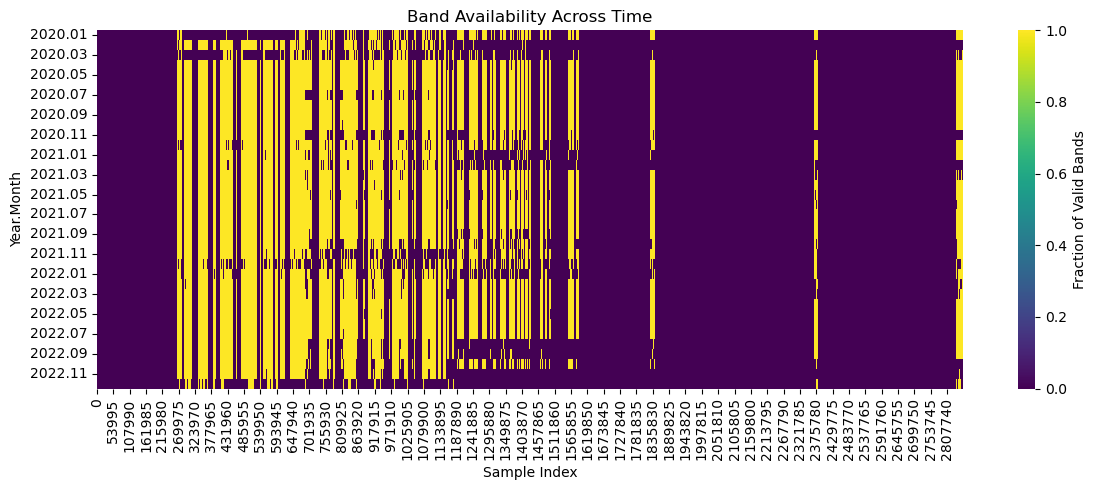

In [9]:
plt.figure(figsize=(12, 5))
sns.heatmap(availability.T, cmap="viridis", cbar_kws={'label': 'Fraction of Valid Bands'})
plt.title("Band Availability Across Time")
plt.xlabel("Sample Index")
plt.ylabel("Year.Month")
plt.tight_layout()
plt.show()

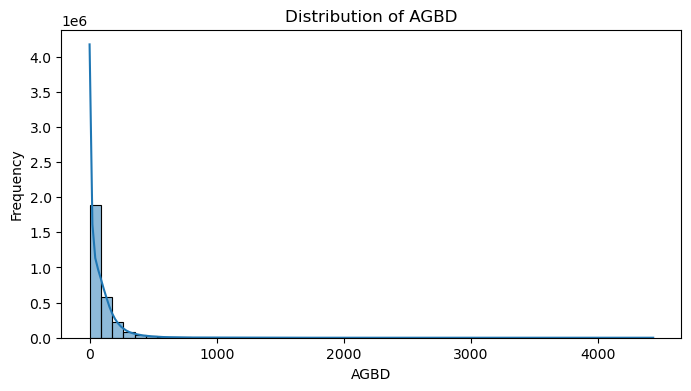

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(training_df["agbd"], bins=50, kde=True)
plt.title("Distribution of AGBD")
plt.xlabel("AGBD")
plt.ylabel("Frequency")
plt.show()

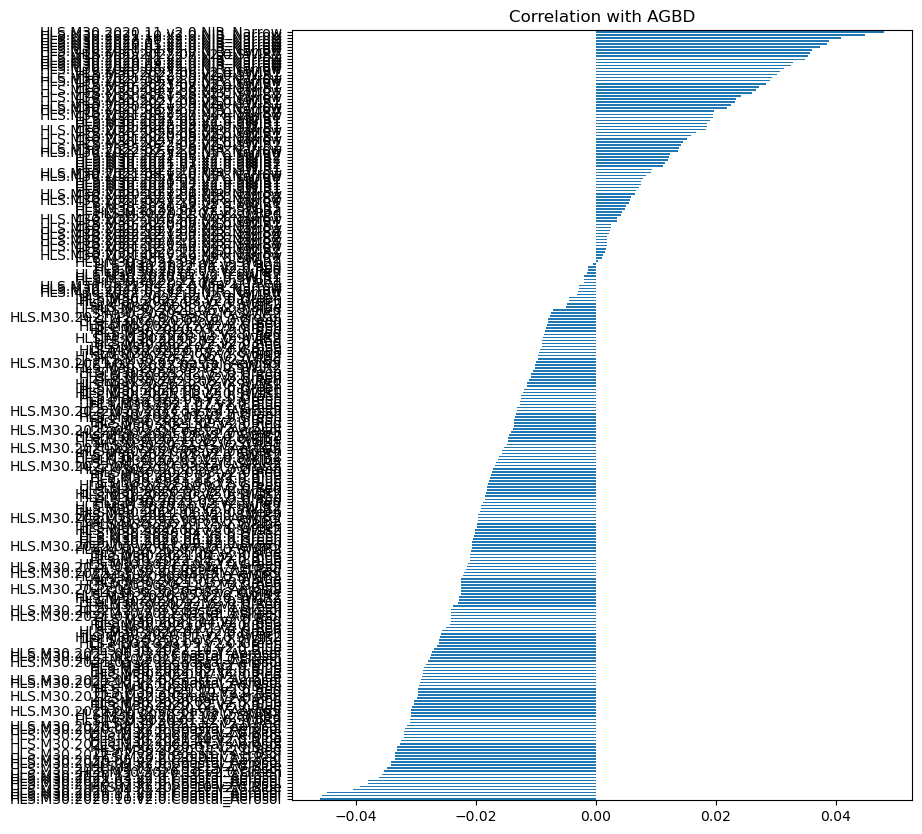

In [11]:
# Correlation of all predictors with AGBD
agbd = training_df['agbd']
correlations = training_df[hls_cols].corrwith(agbd)
correlations.sort_values().plot(kind='barh', figsize=(8, 10), title='Correlation with AGBD')
plt.show()

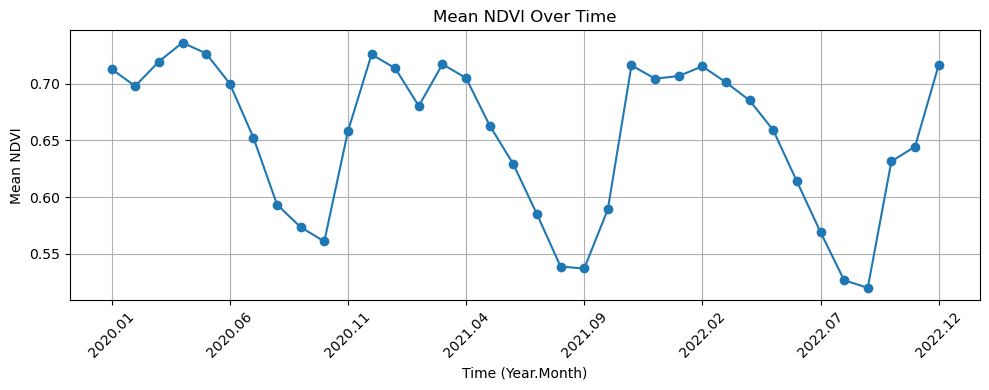

In [13]:
# Temporal Mean of NDVI-like Metric (e.g., NIR - Red)
ndvi_per_time = {}

for t in hls_by_time:
    bands = hls_by_time[t]
    
    red = next((b for b in bands if "Red" in b), None)
    nir = next((b for b in bands if "NIR_Narrow" in b), None)

    if red is None or nir is None:
        continue  # Skip if bands not present

    try:
        red_values = pd.to_numeric(training_df[red], errors='coerce')
        nir_values = pd.to_numeric(training_df[nir], errors='coerce')

        # Compute NDVI
        ndvi = (nir_values - red_values) / (nir_values + red_values + 1e-5)
        ndvi_per_time[t] = ndvi.mean()
    except Exception as e:
        print(f"Skipping {t} due to error: {e}")
        continue


# Plot NDVI temporal trend
plt.figure(figsize=(10, 4))
pd.Series(ndvi_per_time).sort_index().plot(marker="o")
plt.title("Mean NDVI Over Time")
plt.ylabel("Mean NDVI")
plt.xlabel("Time (Year.Month)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

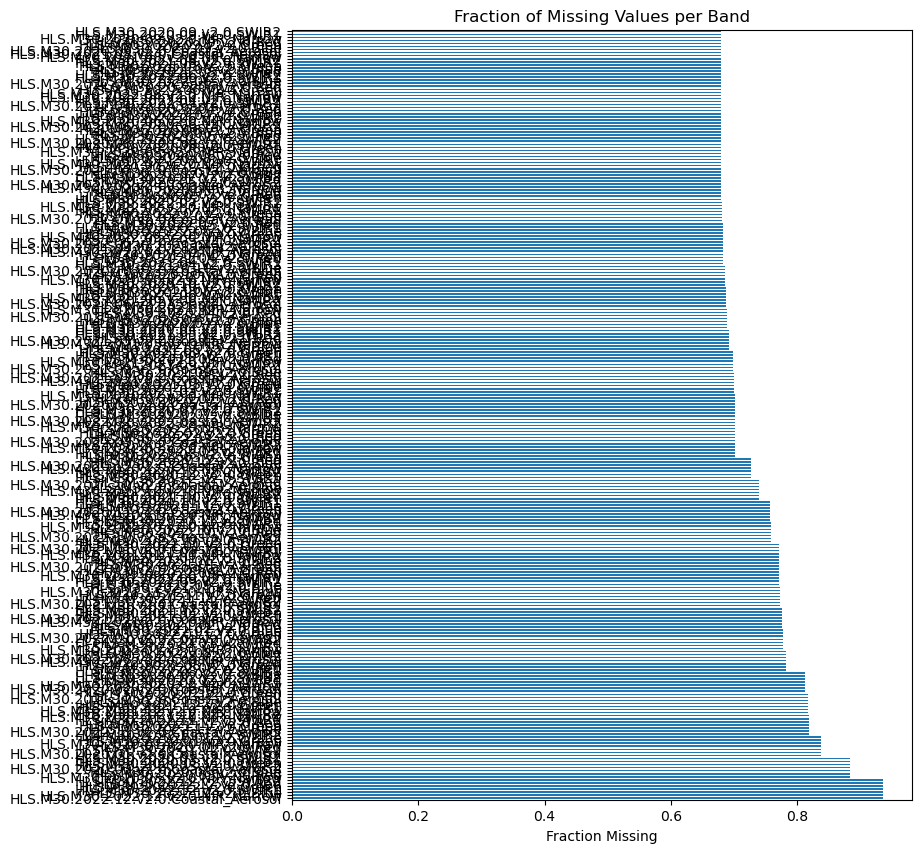

In [14]:
# Missing Value Histogram per Band
missing_fraction = training_df[hls_cols].isna().mean()
missing_fraction.sort_values(ascending=False).plot(kind='barh', figsize=(8, 10), title='Fraction of Missing Values per Band')
plt.xlabel("Fraction Missing")
plt.show()

In [15]:
def preprocess_hls_df(
    df: pd.DataFrame,
    hls_cols: list,
    target_col: str = "agbd",
    strategy: str = "interpolate",  # options: "interpolate" or "drop"
    fill_value: float = 0,
    clip_agbd: tuple = (0, 500),
    log_transform: bool = False
) -> pd.DataFrame:
    """
    Preprocess the HLS dataframe by handling missing data and transforming the target.
    
    Parameters:
        df (pd.DataFrame): Original dataframe
        hls_cols (list): List of HLS column names
        target_col (str): Name of the AGBD column
        strategy (str): "interpolate" or "drop"
        fill_value (float): Value to fill after interpolation (if used)
        clip_agbd (tuple): (min, max) values to clip AGBD
        log_transform (bool): Whether to apply log1p transform to AGBD
    
    Returns:
        pd.DataFrame: Processed dataframe
    """
    df = df.copy()

    # Step 1: Ensure all HLS columns are numeric
    df[hls_cols] = df[hls_cols].apply(pd.to_numeric, errors="coerce")

    if strategy == "interpolate":
        # Interpolate and fill remaining NaNs
        df[hls_cols] = df[hls_cols].interpolate(axis=1, limit_direction='both')
        df[hls_cols] = df[hls_cols].fillna(fill_value)
    elif strategy == "drop":
        # Drop rows with any NaNs in predictors
        df = df.dropna(subset=hls_cols)
    else:
        raise ValueError(f"Invalid strategy: {strategy}. Use 'interpolate' or 'drop'.")

    # Optional: Clip AGBD to remove extreme outliers
    if clip_agbd is not None:
        df = df[(df[target_col] > clip_agbd[0]) & (df[target_col] < clip_agbd[1])]

    # Optional: Log-transform the AGBD target
    if log_transform:
        df[f"{target_col}_log"] = np.log1p(df[target_col])
        print(f"✅ Applied log1p transform to '{target_col}' → New column: '{target_col}_log'")
    
    print(f"✅ Preprocessed DataFrame: {len(df)} rows")
    return df

In [16]:
# Step 0: Copy the original DataFrame
gdf_interp = training_df.copy()  # or training_df.copy() if that's what you're using
print("Before preprocessing: ", gdf_interp.shape)

# Step 1: Ensure all HLS columns are float
# gdf_interp[hls_cols] = gdf_interp[hls_cols].apply(pd.to_numeric, errors='coerce')

# Step 2: Interpolate missing values across time (row-wise)
# gdf_interp[hls_cols] = gdf_interp[hls_cols].interpolate(axis=1, limit_direction='both')

# Step 3: Fill any remaining NaNs with 0 (or -999 if you prefer to flag missingness)
# gdf_interp[hls_cols] = gdf_interp[hls_cols].fillna(0)

# Step 4 (optional): Remove outliers from AGBD
# gdf_interp = gdf_interp[(gdf_interp["agbd"] > 0) & (gdf_interp["agbd"] < 500)]

# Choose strategy: "interpolate" or "drop"
gdf_interp = preprocess_hls_df(
    gdf_interp,
    hls_cols,
    strategy="drop",
    fill_value=0,
    clip_agbd=None,
    log_transform=False
)
print("After preprocessing: ", gdf_interp.shape)

Before preprocessing:  (2861722, 523)
✅ Preprocessed DataFrame: 4716 rows
After preprocessing:  (4716, 523)


In [17]:
# log file changes
gdf_interp["agbd_log"] = np.log1p(gdf_interp["agbd"])

/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [18]:
# Standardize all HLS predictors
scaler = StandardScaler()
gdf_interp[hls_cols] = scaler.fit_transform(gdf_interp[hls_cols])

In [19]:
# Train/val split
train_df, val_df = train_test_split(gdf_interp, test_size=0.2, random_state=42)

In [20]:
class HLSDataset(Dataset):
    def __init__(self, df, hls_by_time, target_col="agbd"):
        self.X = []
        self.y = df[target_col].astype("float32").values
        for _, row in df.iterrows():
            sample = []
            for t in sorted(hls_by_time.keys()):
                bands = row[hls_by_time[t]].values.astype("float32")
                sample.append(bands)
            self.X.append(sample)
        self.X = torch.tensor(self.X)  # Shape: [N, T, B]
        self.y = torch.tensor(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
class HLS1DCNN(nn.Module):
    def __init__(self, in_channels, n_bands, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=n_bands, out_channels=hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # Input shape: [B, T, BANDS] → Transpose to [B, BANDS, T]
        x = x.permute(0, 2, 1)
        return self.net(x).squeeze()


class ResidualBlock1D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class AttentionPooling(nn.Module):
    def __init__(self, channels, seq_len):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv1d(channels, 1, kernel_size=1),  # shape: [B, 1, T]
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        weights = self.attn(x)  # [B, 1, T]
        return (x * weights).sum(dim=-1)  # Weighted sum over T

class ResNet1DAttn(nn.Module):
    def __init__(self, in_channels, seq_len, n_blocks=4, hidden_dim=64):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, hidden_dim, kernel_size=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock1D(hidden_dim) for _ in range(n_blocks)])
        self.attn_pool = AttentionPooling(hidden_dim, seq_len)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [B, T, BANDS] → [B, BANDS, T]
        x = x.permute(0, 2, 1)
        x = self.input_proj(x)            # [B, H, T]
        x = self.res_blocks(x)            # [B, H, T]
        x = self.attn_pool(x)             # [B, H]
        return self.fc(x).squeeze(1)      # [B]


In [22]:
# Create datasets
# choose between "agbd" or "agbd_log"
target_col = "agbd"
train_ds = HLSDataset(train_df, hls_by_time, target_col=target_col)
val_ds = HLSDataset(val_df, hls_by_time, target_col=target_col)

/explore/nobackup/people/jacaraba/.nccstmp/ipykernel_1082950/3906751392.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439675/work/torch/csrc/utils/tensor_new.cpp:278.)
  self.X = torch.tensor(self.X)  # Shape: [N, T, B]


In [23]:
# Check input data
print("Any NaNs in X (train):", torch.isnan(train_ds.X).any().item())
print("Any Infs in X (train):", torch.isinf(train_ds.X).any().item())

print("Any NaNs in Y (train):", torch.isnan(train_ds.y).any().item())
print("Any Infs in Y (train):", torch.isinf(train_ds.y).any().item())

Any NaNs in X (train): False
Any Infs in X (train): False
Any NaNs in Y (train): False
Any Infs in Y (train): False


In [24]:
# Data loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [25]:
# Model init
example_time = sorted(hls_by_time.keys())[0]
n_bands = len(hls_by_time[example_time])
n_timesteps = len(hls_by_time)

In [26]:
# Initialize model
# model = HLS1DCNN(in_channels=n_timesteps, n_bands=n_bands)
model = ResNet1DAttn(in_channels=n_bands, seq_len=n_timesteps)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet1DAttn(
  (input_proj): Conv1d(7, 64, kernel_size=(1,), stride=(1,))
  (res_blocks): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResidualBlock1D(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): Batch

In [27]:
# Optimizer & loss
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [28]:
# Make sure output dir exists
os.makedirs("checkpoints", exist_ok=True)

best_val_loss = float("inf")
patience = 10
patience_counter = 0
epochs = 200  # Allow early stopping to trigger

for epoch in range(epochs):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    # Validation
    model.eval()
    val_losses = []
    val_targets = []
    val_preds = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_losses.append(loss.item())
            val_targets.append(yb.cpu().numpy())
            val_preds.append(pred.cpu().numpy())

    val_loss = np.mean(val_losses)
    y_true = np.concatenate(val_targets)
    y_pred = np.concatenate(val_preds)

    # Metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)

    print(f"🌀 Epoch {epoch+1:03d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"R²: {r2:.3f} | MAE: {mae:.3f} | RMSE: {rmse:.3f}")

    # Save model this epoch
    model_path = f"checkpoints/epoch_{epoch+1:03d}_val{val_loss:.4f}.pt"
    torch.save(model.state_dict(), model_path)

    # Update best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        best_epoch = epoch + 1
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch+1}")
            break

# Restore best model
model.load_state_dict(best_model_state)
print(f"\n✅ Loaded best model from epoch {best_epoch} with val loss {best_val_loss:.4f}")


🌀 Epoch 001 | Train Loss: 28947.0510 | Val Loss: 12979.1793 | R²: -0.021 | MAE: 69.710 | RMSE: 13145.488
🌀 Epoch 002 | Train Loss: 23572.1367 | Val Loss: 13280.1596 | R²: -0.042 | MAE: 77.347 | RMSE: 13414.697
🌀 Epoch 003 | Train Loss: 23001.4569 | Val Loss: 12477.0835 | R²: 0.020 | MAE: 76.160 | RMSE: 12614.414
🌀 Epoch 004 | Train Loss: 22221.0618 | Val Loss: 13521.9171 | R²: -0.062 | MAE: 73.350 | RMSE: 13672.812
🌀 Epoch 005 | Train Loss: 21617.1439 | Val Loss: 12248.4142 | R²: 0.038 | MAE: 71.162 | RMSE: 12384.897
🌀 Epoch 006 | Train Loss: 20886.6110 | Val Loss: 12082.6231 | R²: 0.050 | MAE: 72.423 | RMSE: 12230.004
🌀 Epoch 007 | Train Loss: 20417.7486 | Val Loss: 11732.5091 | R²: 0.079 | MAE: 71.861 | RMSE: 11856.464
🌀 Epoch 008 | Train Loss: 18921.6817 | Val Loss: 12711.5485 | R²: 0.001 | MAE: 74.657 | RMSE: 12857.152
🌀 Epoch 009 | Train Loss: 17976.3931 | Val Loss: 12209.0485 | R²: 0.040 | MAE: 69.782 | RMSE: 12358.928
🌀 Epoch 010 | Train Loss: 17018.1649 | Val Loss: 11235.1506 |

In [31]:
def predict(model, dataloader, target_col="agbd"):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            yb = yb.cpu().numpy()
            preds.extend(pred)
            targets.extend(yb)

    preds = np.array(preds)
    targets = np.array(targets)

    # Reverse log-transform if needed
    if target_col == "agbd_log":
        preds = np.expm1(preds)
        targets = np.expm1(targets)

    return preds, targets


In [34]:
val_preds, val_targets = predict(model, val_loader, target_col="agbd")

📊 R²: 0.7999 | MAE: 25.88 | RMSE: 50.76


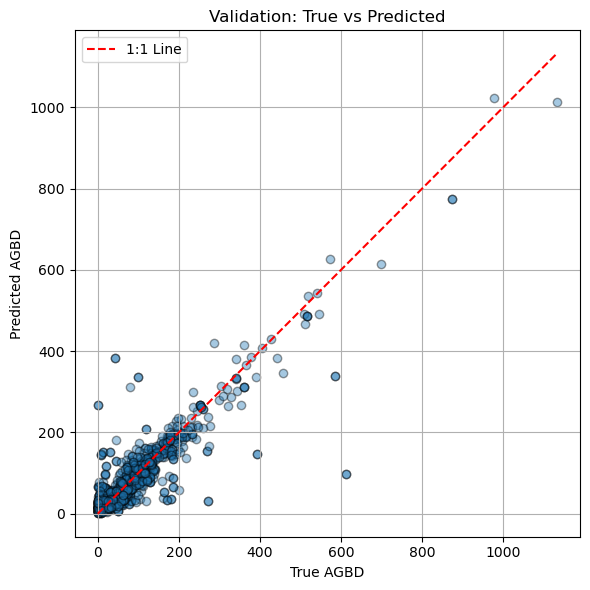

In [35]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Metrics
r2 = r2_score(val_targets, val_preds)
mae = mean_absolute_error(val_targets, val_preds)
rmse = np.sqrt(mean_squared_error(val_targets, val_preds))

print(f"📊 R²: {r2:.4f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")

# Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(val_targets, val_preds, alpha=0.4, edgecolor='k')
plt.plot([val_targets.min(), val_targets.max()],
         [val_targets.min(), val_targets.max()],
         '--r', label='1:1 Line')
plt.xlabel("True AGBD")
plt.ylabel("Predicted AGBD")
plt.title("Validation: True vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance

In [36]:
import numpy as np
from copy import deepcopy
from sklearn.metrics import r2_score

def compute_permutation_importance(model, dataset, target_col="agbd", baseline_r2=None):
    model.eval()
    X = dataset.X.clone()  # [N, T, B]
    y = dataset.y.clone().numpy()

    if target_col == "agbd_log":
        y = np.expm1(y)

    # Baseline prediction
    with torch.no_grad():
        preds = model(X.to(device)).cpu().numpy()
    if target_col == "agbd_log":
        preds = np.expm1(preds)
    baseline_r2 = baseline_r2 or r2_score(y, preds)

    importances = np.zeros_like(X[0])  # [T, B]
    print("📊 Running permutation importance...")

    for t in range(X.shape[1]):  # Time
        for b in range(X.shape[2]):  # Band
            X_perturbed = X.clone()
            perm = torch.randperm(X.shape[0])
            X_perturbed[:, t, b] = X[perm, t, b]  # Permute feature

            with torch.no_grad():
                pred_perm = model(X_perturbed.to(device)).cpu().numpy()
            if target_col == "agbd_log":
                pred_perm = np.expm1(pred_perm)

            r2_perturbed = r2_score(y, pred_perm)
            importances[t, b] = baseline_r2 - r2_perturbed  # R² drop = importance

    print("✅ Done.")
    return importances  # Shape: [T, B]


📊 Running permutation importance...
✅ Done.


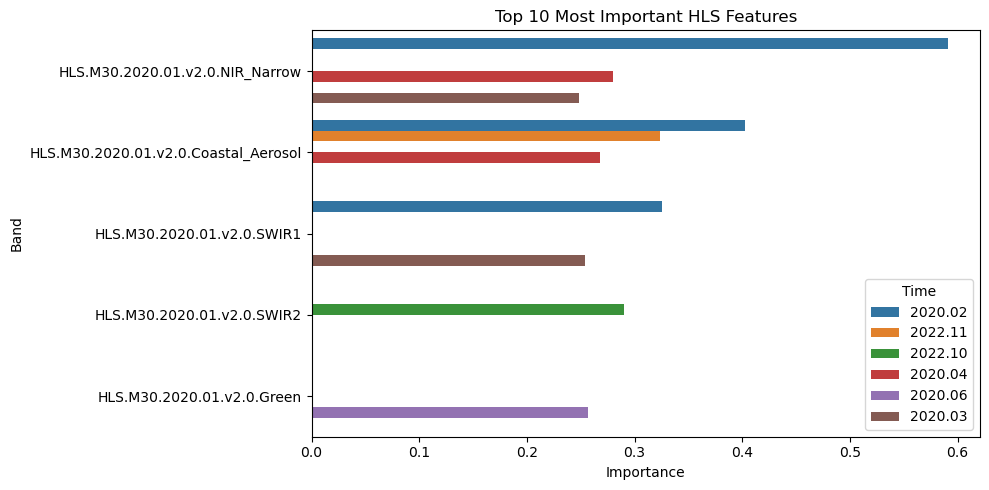

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

importance_matrix = compute_permutation_importance(model, val_ds, target_col="agbd")

# Map to column names
time_steps = sorted(hls_by_time.keys())
band_names = hls_by_time[time_steps[0]]  # assumes all timesteps use same bands

imp_df = pd.DataFrame(importance_matrix, index=time_steps, columns=band_names)

# Flatten and sort
flat_imp = imp_df.stack().reset_index()
flat_imp.columns = ["Time", "Band", "Importance"]
flat_imp = flat_imp.sort_values("Importance", ascending=False)

# Plot top 10
plt.figure(figsize=(10, 5))
sns.barplot(data=flat_imp.head(10), x="Importance", y="Band", hue="Time")
plt.title("Top 10 Most Important HLS Features")
plt.tight_layout()
plt.show()


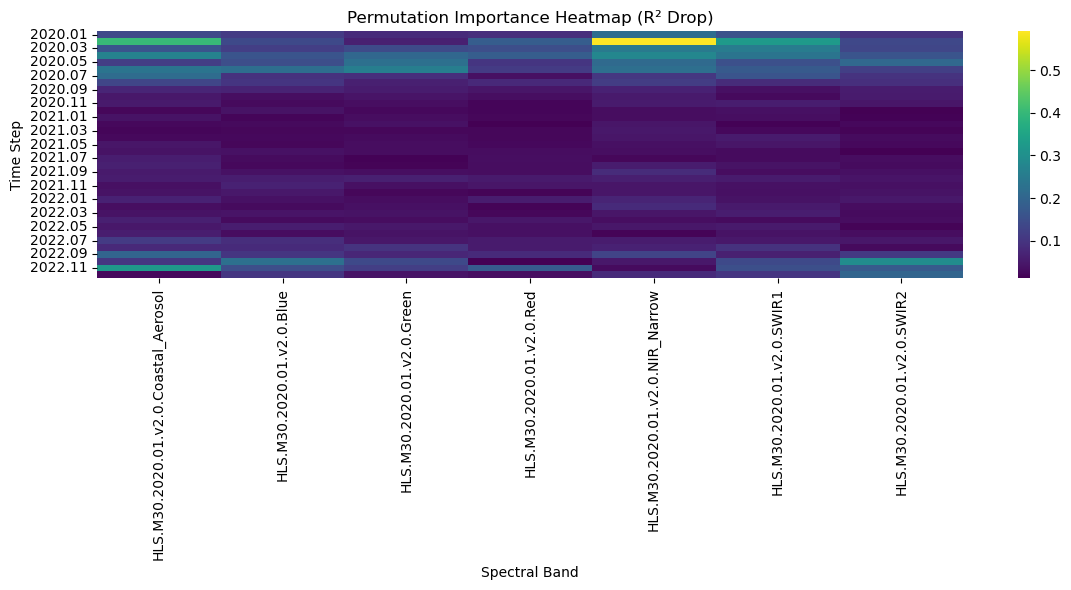

In [39]:
time_steps = sorted(hls_by_time.keys())
band_names = hls_by_time[time_steps[0]]
imp_df = pd.DataFrame(importance_matrix, index=time_steps, columns=band_names)

# Heatmap
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(imp_df, cmap="viridis", annot=False)
plt.title("Permutation Importance Heatmap (R² Drop)")
plt.xlabel("Spectral Band")
plt.ylabel("Time Step")
plt.tight_layout()
plt.show()